# Initialization

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import glob
import pandas as pd
import matplotlib.pyplot as plt

2024-07-08 17:01:02.694486: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import configs

# Classification-Guided UNet (CGUNet)

In [ ]:
def double_conv_block(x, n_filters):
    x = tf.keras.layers.Conv2D(n_filters, 3, padding="same",
                        activation="relu", kernel_initializer="he_normal")(x)
    x = tf.keras.layers.Conv2D(n_filters, 3, padding="same", activation="relu",
                        kernel_initializer="he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    p = tf.keras.layers.Dropout(0.5)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = tf.keras.layers.concatenate([x, conv_features])
    x = tf.keras.layers.Dropout(0.5)(x)
    x = double_conv_block(x, n_filters)
    return x

def build_unet_model(input_shape, name):
    inputs = tf.keras.layers.Input(shape=input_shape)

    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)

    bottleneck = double_conv_block(p3, 512)

    u7 = upsample_block(bottleneck, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    # outputs_img
    outputs_img = tf.keras.layers.Conv2D(3, 1, padding="same",
                            activation = "sigmoid", name="out_img")(u9)

    # outputs_class
    gap = tf.keras.layers.GlobalAveragePooling2D()(bottleneck)
    d1 = tf.keras.layers.Dense(256, activation='sigmoid')(gap)
    drop1 = tf.keras.layers.Dropout(0.5)(d1)
    d2 = tf.keras.layers.Dense(64, activation='sigmoid')(drop1)
    drop2 = tf.keras.layers.Dropout(0.5)(d2)
    d3 = tf.keras.layers.Dense(7, activation='sigmoid')(drop2)
    outputs_class = tf.keras.layers.Softmax(name="out_class")(d3)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs=[outputs_img, outputs_class],
                                name=name)

    return unet_model

In [ ]:
model = build_unet_model(configs.IMAGE_SIZE, "CGUNet")
model.summary()

Model: "unet_classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_181 (Conv2D)         (None, 224, 224, 64)         1792      ['input_15[0][0]']            
                                                                                                  
 conv2d_182 (Conv2D)         (None, 224, 224, 64)         36928     ['conv2d_181[0][0]']          
                                                                                                  
 max_pooling2d_49 (MaxPooli  (None, 112, 112, 64)         0         ['conv2d_182[0][0]']          
 ng2D)                                                                              

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
              loss={'out_img':tf.losses.MeanSquaredError(),
                      'out_class':tf.losses.CategoricalCrossentropy()},
              metrics={'out_class':'accuracy'})

# Training

In [ ]:
class MyDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dir, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.filenames = glob.glob(data_dir + '/*/*.jpg')
        self.filenames.sort()
        print(len(self.filenames), 'found')
        self.classnames = ['/akiec/', '/bcc/', '/bkl/',
                           '/df/', '/mel/', '/nv/', '/vasc/']
        self.indices = None
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        filenames = [self.filenames[k] for k in indices]
        X, Y = self.__data_generation(filenames)
        return X, Y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def filename2onehot(self, fn):
        for i in range(configs.NUM_CLASS):
            if self.classnames[i] in fn:
                result = np.zeros(configs.NUM_CLASS, dtype=np.float64)
                result[i] = 1
                return result
        return None

    def __data_generation(self, filenames):
        num = len(filenames)
        X = np.empty([num, *configs.IMAGE_SIZE], dtype=np.float64)
        Y_class = np.empty([num, configs.NUM_CLASS])
        for i, fn in enumerate(filenames):
            img = cv2.imread(fn)
            delta = (configs.IMAGE_SIZE[1] - configs.IMAGE_SIZE[0]) // 2
            img = img[:, delta:configs.IMAGE_SIZE[1]-delta-1]
            img = cv2.resize(img, (224, 224))
            X[i] = np.array(img, dtype=np.float64) / 255.
            Y_class[i] = self.filename2onehot(fn)

        return X, {'out_img':X, 'out_class':Y_class}

In [ ]:
train_datagen = MyDataGenerator(configs.DATA_DIR+'/train')
val_datagen = MyDataGenerator(configs.DATA_DIR+'/val')
test_datagen = MyDataGenerator(configs.DATA_DIR+'/test')

5005 found
2000 found
3010 found


In [ ]:
X, Ys = val_datagen[0]

(32, 224, 224, 3)


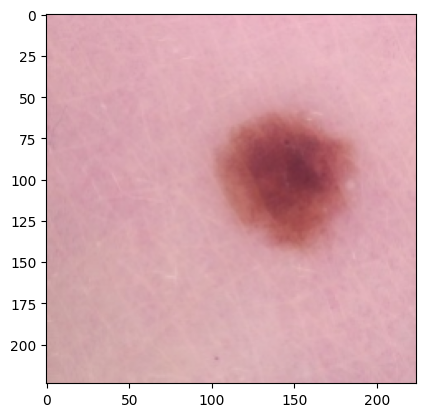

In [ ]:
print(X.shape)
plt.imshow(cv2.cvtColor((X[0]*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
cb_early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=8,
    verbose=1,
    mode='auto'
)
cb_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    configs.CHECKPOINT_DIR + '/' + model.name,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto'
)
cb_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    mode='auto',
    min_delta=1e-4,
    min_lr=0
)
callbacks = [cb_model_checkpoint,
             cb_reduce_lr,
             cb_early_stop]

In [ ]:
history = model.fit_generator(train_datagen,
                    epochs=2024,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=val_datagen)

pd.DataFrame.from_dict(history.history) \
           .to_csv(configs.CHECKPOINT_DIR + '/' + model.name +
                   '/history_unet_classifer.csv', index=False)

<ipython-input-10-0fcfb24bfcc6>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen,


Epoch 1/2024
157/157 [==============================] - ETA: 0s - loss: 1.5036 - out_img_loss: 0.0012 - out_class_loss: 1.5024 - out_class_accuracy: 0.6695
Epoch 1: val_loss improved from inf to 1.49387, saving model to HAM10000/unet_classifier
157/157 [==============================] - 1709s 11s/step - loss: 1.5036 - out_img_loss: 0.0012 - out_class_loss: 1.5024 - out_class_accuracy: 0.6695 - val_loss: 1.4939 - val_out_img_loss: 0.0038 - val_out_class_loss: 1.4900 - val_out_class_accuracy: 0.6705 - lr: 1.0000e-04
Epoch 2/2024
157/157 [==============================] - ETA: 0s - loss: 1.4983 - out_img_loss: 0.0012 - out_class_loss: 1.4971 - out_class_accuracy: 0.6697
Epoch 2: val_loss improved from 1.49387 to 1.48542, saving model to HAM10000/unet_classifier
157/157 [==============================] - 231s 1s/step - loss: 1.4983 - out_img_loss: 0.0012 - out_class_loss: 1.4971 - out_class_accuracy: 0.6697 - val_loss: 1.4854 - val_out_img_loss: 0.0047 - val_out_class_loss: 1.4807 - val_ou

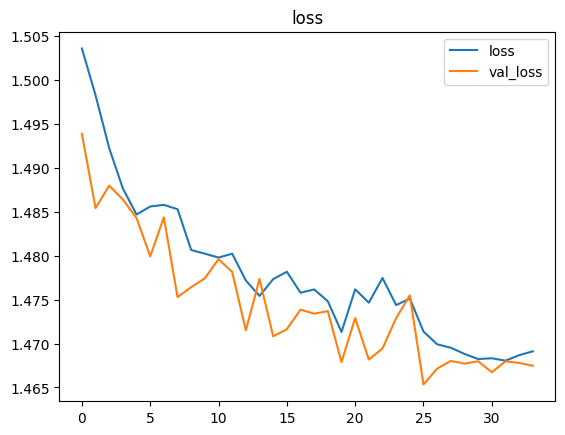

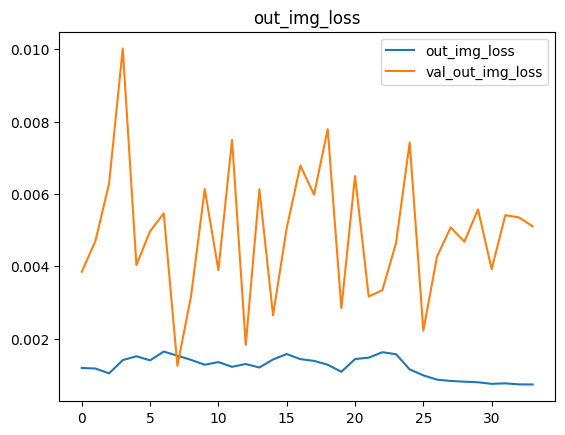

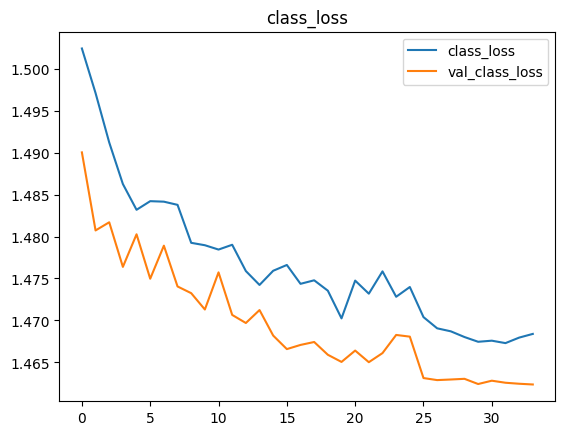

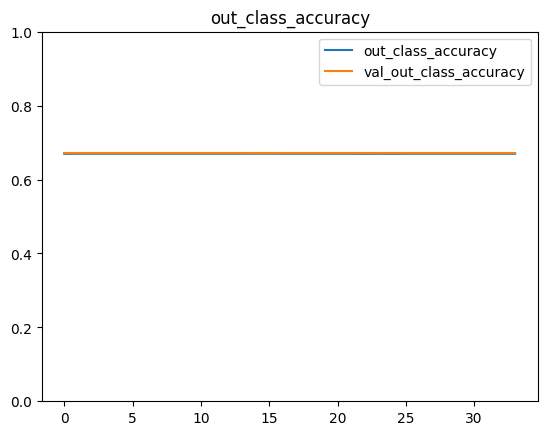

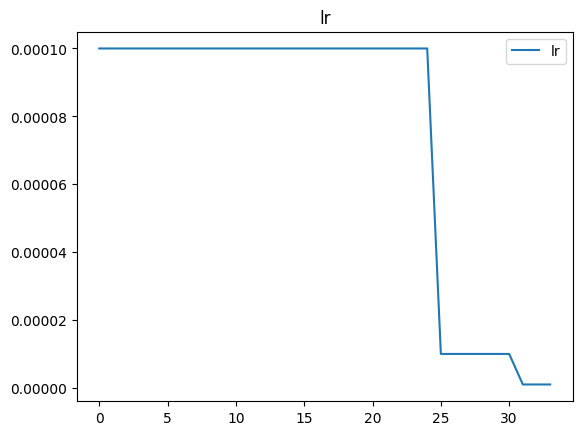

In [3]:
df = pd.read_csv(configs.CGUNET_CHECKPOINT +
                 '/history_unet_classifer-20240420213200.csv')

# plt.subplot(5, 1, 1)
plt.plot(df['loss'], label='loss')
plt.plot(df['val_loss'], label='val_loss')
plt.legend()
plt.title('loss')
plt.show()

# plt.subplot(5, 1, 2)
plt.plot(df['out_img_loss'], label='out_img_loss')
plt.plot(df['val_out_img_loss'], label='val_out_img_loss')
plt.legend()
plt.title('out_img_loss')
plt.show()

# plt.subplot(5, 1, 3)
plt.plot(df['out_class_loss'], label='class_loss')
plt.plot(df['val_out_class_loss'], label='val_class_loss')
plt.legend()
plt.title('class_loss')
plt.show()

# plt.subplot(5, 1, 4)
plt.plot(df['out_class_accuracy'], label='out_class_accuracy')
plt.plot(df['val_out_class_accuracy'], label='val_out_class_accuracy')
plt.legend()
plt.title('out_class_accuracy')
plt.ylim(0, 1)
plt.show()

# plt.subplot(5, 1, 5)
plt.plot(df['lr'], label='lr')
plt.legend()
plt.title('lr')
plt.show()

# plt.legend()
# plt.tight_layout()
# plt.show()

# Evaluation

In [ ]:
model = tf.keras.models.load_model(configs.CGUNET_CHECKPOINT)
train_loss, train_acc = model.evaluate_generator(train_datagen, verbose=1)
val_loss, val_acc = model.evaluate_generator(val_datagen, verbose=1)
test_evals = model.evaluate_generator(test_datagen, verbose=1)

<ipython-input-17-fc46548dd081>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_evals = model.evaluate_generator(test_datagen, verbose=1)


95/95 [==============================] - 1224s 13s/step - loss: 1.4705 - out_img_loss: 0.0022 - out_class_loss: 1.4683 - out_class_accuracy: 0.6684


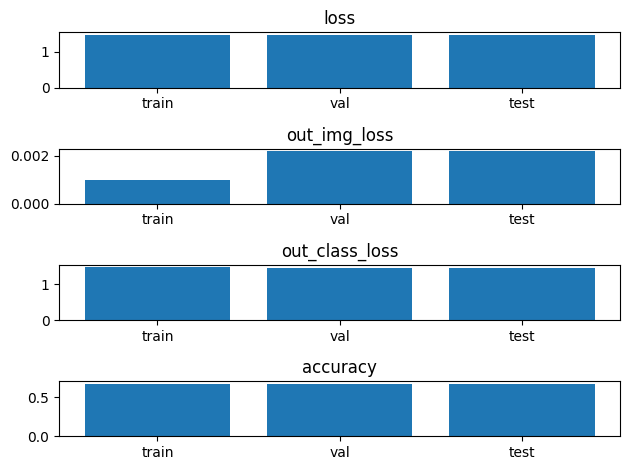

In [ ]:
plt.subplot(4, 1, 1)
plt.bar(['train', 'val', 'test'], [1.4714, 1.4653, 1.4705]) # loss
plt.title('loss')
plt.subplot(4, 1, 2)
plt.bar(['train', 'val', 'test'], [9.8030e-04, 0.0022, 0.0022]) # out_img_loss
plt.title('out_img_loss')
plt.subplot(4, 1, 3)
plt.bar(['train', 'val', 'test'], [1.4704, 1.4631, 1.4683]) # out_class_loss
plt.title('out_class_loss')
plt.subplot(4, 1, 4)
plt.bar(['train', 'val', 'test'], [0.6697, 0.6705, 0.6684]) # accuracy
plt.title('accuracy')
plt.tight_layout()
plt.show()

In [ ]:
Xs, Ys = val_datagen[0]
print(Xs.shape, Ys.keys())

(32, 224, 224, 3) dict_keys(['out_img', 'out_class'])


In [ ]:
Y_s = model.predict(Xs)

1/1 [==============================] - 34s 34s/step


In [ ]:
decoded_imgs = Y_s[0]
print(decoded_imgs.shape)

(32, 224, 224, 3)


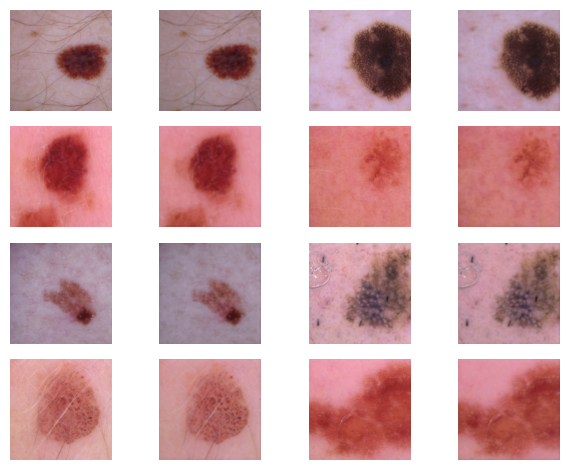

In [ ]:
def toRGB(img):
  img = np.array(img * 255, dtype=np.uint8)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

for i in range(16):
  plt.subplot(4, 4, i+1)
  if i % 2 == 0:
    plt.imshow(toRGB(Xs[i]))
    # plt.title('original')
  else:
    plt.imshow(toRGB(decoded_imgs[i-1]))
    # plt.title('decoded')
  plt.axis('off')

plt.tight_layout()
plt.show()